# Import libraries

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Create corpus

In [2]:
root_dir = "/kaggle/input/poemsdataset/topics"
corpus = []
corpus_size = 10000
done = False

print("Loading poems in corpus...\n")
for dirname, _, filenames in os.walk(root_dir):
    if done: break
    print(f"Loading {dirname}")
    for filename in filenames:
        if done: break
        with open(os.path.join(dirname, filename), "r") as file:
            txt = file.read()
            for line in txt.split("\n"):
                if done: break
                corpus.append(line)
                if len(corpus) == corpus_size:
                    done = True

Loading poems in corpus...

Loading /kaggle/input/poemsdataset/topics
Loading /kaggle/input/poemsdataset/topics/moon
Loading /kaggle/input/poemsdataset/topics/beauty
Loading /kaggle/input/poemsdataset/topics/joy
Loading /kaggle/input/poemsdataset/topics/hero


In [3]:
len(corpus)

10000

In [4]:
corpus[:10]

["Press'd by the Moon, mute arbitress of tides,",
 'While the loud equinox its power combines,',
 'The sea no more its swelling surge confines,',
 "But o'er the shrinking land sublimely rides.",
 'The wild blast, rising from the Western cave,',
 'Drives the huge billows from their heaving bed;',
 'Tears from their grassy tombs the village dead,',
 'And breaks the silent sabbath of the grave!',
 'With shells and sea-weed mingled, on the shore',
 'Lo! their bones whiten in the frequent wave;']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [5]:
import string

def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

corpus = [ remove_punc(s.lower().strip()) for s in corpus ]

In [6]:
corpus[:10]

['pressd by the moon mute arbitress of tides',
 'while the loud equinox its power combines',
 'the sea no more its swelling surge confines',
 'but oer the shrinking land sublimely rides',
 'the wild blast rising from the western cave',
 'drives the huge billows from their heaving bed',
 'tears from their grassy tombs the village dead',
 'and breaks the silent sabbath of the grave',
 'with shells and seaweed mingled on the shore',
 'lo their bones whiten in the frequent wave']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [7]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9340


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [9]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 58453
Maximum n-gram length: 262


In [10]:
for n_gram in n_grams[:10]:
    print(n_gram)

[4218, 42]
[4218, 42, 1]
[4218, 42, 1, 33]
[4218, 42, 1, 33, 1014]
[4218, 42, 1, 33, 1014, 4219]
[4218, 42, 1, 33, 1014, 4219, 3]
[4218, 42, 1, 33, 1014, 4219, 3, 1325]
[150, 1]
[150, 1, 914]
[150, 1, 914, 4220]


## Pad n-grams

In [11]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(58453, 100)

In [12]:
for seq in padded_n_grams[:3]:
    print(seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 4218   42]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

## Split n-grams into X and y

In [13]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (58453, 99)
y: (58453,)


In [14]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (58453, 9340)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [15]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 300)           2802000   
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 9340)              1410340   
                                                                 
Total params: 4,482,940
Trainable params: 4,482,940
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125
457/457 [==============================] - 41s 81ms/step - loss: 7.2782 - accuracy: 0.0512
Epoch 2/125
457/457 [==============================] - 13s 27ms/step - loss: 6.7800 - accuracy: 0.0708
Epoch 3/125
457/457 [==============================] - 10s 21ms/step - loss: 6.5152 - accuracy: 0.0832
Epoch 4/125
457/457 [==============================] - 9s 19ms/step - loss: 6.3136 - accuracy: 0.0923
Epoch 5/125
457/457 [==============================] - 8s 18ms/step - loss: 6.1265 - accuracy: 0.1006
Epoch 6/125
457/457 [==============================] - 8s 18ms/step - loss: 5.9448 - accuracy: 0.1077
Epoch 7/125
457/457 [==============================] - 8s 17ms/step - loss: 5.7663 - accuracy: 0.1160
Epoch 8/125
457/457 [==============================] - 9s 19ms/step - loss: 5.5873 - accuracy: 0.1252
Epoch 9/125
457/457 [==============================] - 8s 18ms/step - loss: 5.4066 - accuracy: 0.1350
Epoch 10/125
457/457 [==============================] - 8s 17ms/step - loss: 5.

# Plot learning curves

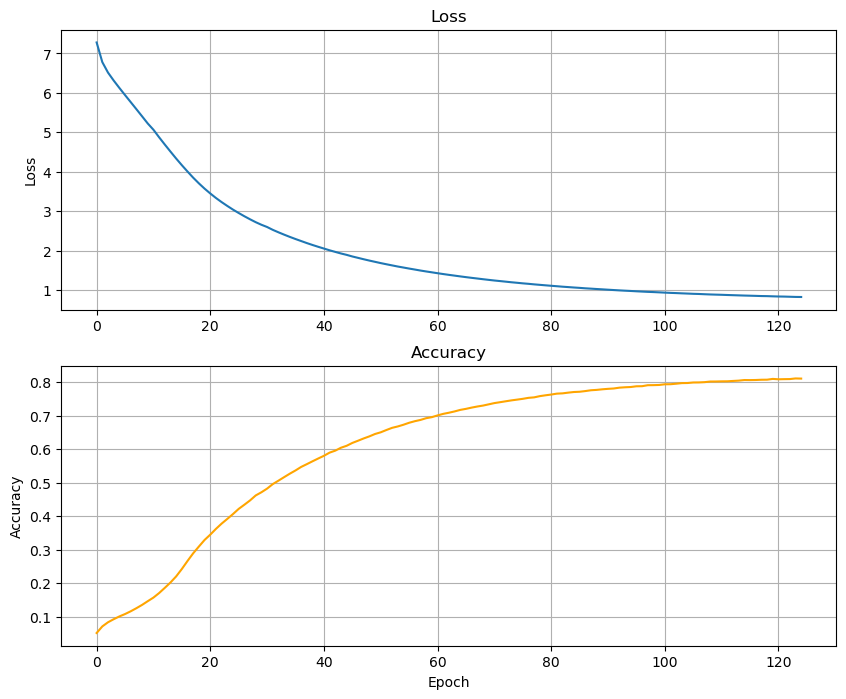

In [17]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [18]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [19]:
generate("Long live the king", 200)

Long live the king and a skimming and follow you to their first movers out of sight and time you have a time of joy in and time you are me in my arms where u and decay at you they for this words that is was best so much i needed a haircut go one to me and we may not the need to wonder the shadow goes fast and the vague which you understand and the mute which will see us a hero didnt have control for just a little at a time you start to know your mistakes when i was steering that car i was swerving but i had her to correct my mistakes her correcting them for me while i was by her side i learned it a lot faster then i would of the one we the song those that have i fear i go his own better have a kind that quivers in book and accuse him of immortality and then we had but a hero is the best still as she is a hero someone who goes that little extra mile against all odds to make the world a better place on today its place but
